In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import numpy as np
from scipy import stats
import caffe
from augmentImages import process_img
from utils import files_list
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [ ]:
caffe.io.skimage.io.imsave()

255

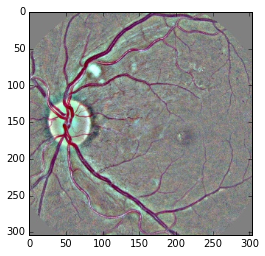

In [112]:
im = (caffe.io.load_image("/home/ubuntu/dataset/200_val/2/9952_left.jpeg") * 255).astype(np.uint8)
plt.imshow(im);
im.max()

## Preprocess test images and make predictions on 5 randomly rotated images 

In [ ]:
model_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-183415-a343/snapshot_iter_26310.caffemodel"
proto_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-183415-a343/deploy.prototxt"
mean_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-180534-3e3b/mean.jpg"
test_path = "/home/ubuntu/dataset/test/test/"
job_id = model_path.split('/')[-2]

In [ ]:
net = caffe.Net(proto_path, model_path, caffe.TEST)

In [ ]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', (caffe.io.load_image(mean_path)*255).mean(0).mean(0))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [ ]:
net.blobs['data'].data[:] = np.asarray([transformer.preprocess('data', im), transformer.preprocess('data', im)])
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax(1)))

In [ ]:
def key_names(f1):
    return int(f1[0].split('/')[-1].split('_')[0])

In [ ]:
names = sorted(files_list(test_path, "test"), key=key_names)
num_files = len(names)
print "Total number of test files: %d" % num_files

In [ ]:
scale = 180
crop_shape = (255, 255)
random_draws = 4
batch_size = 40
uniq_im_per_batch = batch_size // (random_draws + 1)

In [ ]:
with Parallel(n_jobs=8) as parallel:
    for i in xrange(0, num_files, uniq_im_per_batch):
        upper_idx = min(i + uniq_im_per_batch, num_files)
        files_batch = names[i:upper_idx]
        num_uniq_im = (upper_idx - i)
        ret = parallel(delayed(process_img)(fname_lab, crop_shape, scale, random_draws, "test", False) 
                       for fname_lab in files_batch)
        ret = np.asarray(ret).reshape((num_uniq_im * (random_draws + 1), crop_shape[0], crop_shape[0], 3))
        if ret.shape[0] < batch_size:
            pad = np.zeros((batch_size - num_uniq_im, crop_shape[0], crop_shape[0], 3), dtype=ret.dtype)
            ret = np.vstack((ret, pad))
        assert ret.shape[0] == batch_size, ("Error: the input batch has lesser number"
                                            " of images than the expected batch size %d" % (batch_size))
        l = []
        for j in range(batch_size):
            l.append(transformer.preprocess('data', ret[j,:,:,:]))
        net.blobs['data'].data[:] = np.asarray(l)
        out = net.forward()
        preds = np.asarray(out['prob'][:num_uniq_im * (random_draws + 1), :].argmax(1))
        preds_im = stats.mode(preds.reshape((num_uniq_im, (random_draws + 1))), axis=1)[0]
        for j in range(num_uniq_im):
            print "%s,%d" % (files_batch[j][0].split('/')[-1].split('.')[0], preds_im[j])
        break

## 2 step model predictions

In [5]:
model_path01 = '/home/ubuntu/model/weight01.caffemodel'
model_path14 = '/home/ubuntu/model/weight14.caffemodel'
dep_path01 = '/home/ubuntu/model/deploy01.prototxt'
dep_path14 = '/home/ubuntu/model/deploy14.prototxt'

In [6]:
net01 = caffe.Net(dep_path01, model_path01, caffe.TEST)
net14 = caffe.Net(dep_path14, model_path14, caffe.TEST)

In [22]:
imgs = np.asarray([im.transpose([2, 0, 1]), im.transpose([2, 0, 1])])

In [23]:
net01.blobs['data'].reshape(*imgs.shape)
net14.blobs['data'].reshape(*imgs.shape)

In [24]:
net01.blobs['data'].data[...] = imgs
net14.blobs['data'].data[...] = imgs

In [102]:
probs01 = net01.forward()['prob']
probs14 = net14.forward()['prob']

In [104]:
get_label_prob(probs01, probs14)

([0.58805424, 0.58805424], [1, 1])

In [108]:
get_label_prob(np.random.uniform(0., 1., size=(2, 2)), np.random.uniform(0., 1., size=(2, 4)))

[[ 0.00107247  0.15639431]
 [ 0.98305176  0.1286418 ]] [[ 0.42140666  0.71431235  0.33339202  0.16694658]
 [ 0.80217344  0.30850837  0.18432419  0.48534198]]


([0.001072472339792796, 0.98305176497495572], [0, 0])

In [103]:
print probs01
print probs14

[[ 0.27213177  0.72786826]
 [ 0.27213177  0.72786826]]
[[ 0.58805424  0.34757814  0.03144999  0.03291757]
 [ 0.58805424  0.34757814  0.03144999  0.03291757]]


In [ ]:
# def get_label_prob(probs01, probs14, thresh_pb1=0.7):
#     res = {}
#     num_imgs = probs01.shape[0]
#     v = (probs01[:, 1] > 0.7).astype(np.uint8)
#     probs = v * probs01[np.arange(num_imgs), probs01.argmax(1)] + (1 - v) * probs14[np.arange(num_imgs), probs14.argmax(1)]
#     labels = np.zeros((num_imgs))
#     labels[v==1] = probs14.argmax(1)[v==1]+1
#     return probs, labels

In [109]:
import cv2
cv2.cvtColor(im, cv2.COLOR_RGB2BGR)

In [107]:
def get_label_prob(probs01, probs14, thresh_pb1=0.7):
    probs = []
    labels = []
    num_imgs = probs01.shape[0]
    print probs01, probs14
    for i in range(num_imgs):
        cl01 = probs01[i, :].argmax()
        if cl01 == 1:
            pb1 = probs01[i, 1] > thresh_pb1
            if pb1:
                cl = probs14[i, :].argmax()
                labels.append(cl + 1)
                pdict = {}
                for j in range(probs14.shape[1]):
                    pdict[j + 1] = round(probs14[i, j], 4)
                probs.append(pdict)
            else:
                labels.append(0)
                probs.append({0: round(probs01[i, 0], 4)})
        else:
            labels.append(0)
            probs.append({0: round(probs01[i, 0], 4)})
    return probs, labels

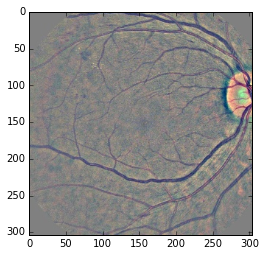

In [115]:
plt.imshow(caffe.io.load_image("/home/ubuntu/dataset/200_val/3/99_right.jpeg"))

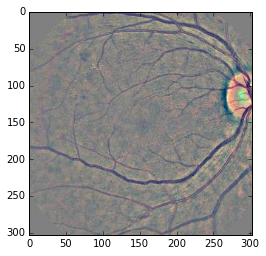

In [120]:
plt.imshow(caffe.io.load_image("/home/ubuntu/99_right.jpeg"))

In [2]:
from subprocess import check_output, STDOUT

In [3]:
from json import loads

In [7]:
fname= '/home/ubuntu/dataset/validation/3/99_right.jpeg'

In [15]:
res01 = check_output("curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151217-070518-faa7 -F image_file=@%s" % (fname), shell=True)
probs = dict(loads(res01)['predictions'])
print probs['%d' % (0)] < probs['%d' % (1)]

False


In [21]:
def get_curl_pred(fname, thresh_pb1=0.7):
    res01 = check_output(
        "curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151217-070518-faa7 -F image_file=@%s" % (fname), shell=True)
    probs01 = dict(loads(res01)['predictions'])
    res14 = check_output(
        "curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151218-081502-a392 -F image_file=@%s" % (fname), shell=True)
    probs14 = dict(loads(res14)['predictions'])
    for k in probs01.iterkeys():
        probs01[k] = round(probs01[k] / 100., 3)
    for k in probs14.iterkeys():
        probs14[k] = round(probs14[k] / 100., 3)
    if probs01['0'] > probs01['1'] or probs01['1'] < thresh_pb1:
        # Best pred level 0
        res = {}
        best_class = 0
        res["level0"] = probs01['0']
        for i in range(1, 4):
            res["level%d" % i] = round(probs01['1'] * probs14['%d' % i], 3)
    else:
        # Best pred level 1, 2, 3 or 4
        res = {}
        best_class = -1
        max_prob = -1.
        res["level0"] = 0.0
        for i in range(1, 4):
            prb = probs14['%d' % i]
            if prb > max_prob:
                max_prob = prb
                best_class = i
            res["level%d" % i] = prb
    return res, best_class

In [16]:
def get_curl_pred1(fname, thresh_pb1=0.7):
    res01 = check_output("curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151217-070518-faa7 -F image_file=@%s" % (fname), shell=True)
    probs01 = dict(loads(res01)['predictions'])
    max_lab = int(probs01[0][0])
    prob_lab = probs01[0][1]/100.
    if max_lab == 1 and prob_lab > thresh_pb1:
        res14 = check_output("curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151218-081502-a392 -F image_file=@%s" % (fname), shell=True)
        probs14 = dict(loads(res14)['predictions'])
        res = {}
        for i in range(4):
            res["level_%d" % (int(probs14[i][0]))] = round(probs14[i][1] / 100., 2)
        best_class = int(probs14[0][0])
    else:
        res = {}
        best_class = 0
        if max_lab == 0:
            res["level_0"] = round(probs01[0][1]/100., 2)
        else:
            res["level_0"] = round(probs01[1][1]/100., 2)
            
    return res, best_class

In [22]:
get_curl_pred(fname)

({'level0': 0.962, 'level1': 0.0, 'level2': 0.031, 'level3': 0.006}, 0)

In [139]:
check_output("curl localhost:5000/models/images/classification/classify_one.json -XPOST -F job_id=20151218-081502-a392 -F image_file=@%s" % (fname), shell=True)

'{\n  "predictions": [\n    [\n      "2", \n      64.77\n    ], \n    [\n      "1", \n      34.51\n    ], \n    [\n      "3", \n      0.7\n    ], \n    [\n      "4", \n      0.02\n    ]\n  ]\n}'